In [1]:
# import package
import pandas as pd
import numpy as np
import os

In [2]:
def uniform_grid_sampling(df, lon_col='LONGITUDE', lat_col='LATITUDE', grid_size=5, samples_per_cell=1):
    df = df.copy()

    # 将坐标划分为网格编号（整数）
    x_bin = (df[lon_col] // grid_size).astype(int)
    y_bin = (df[lat_col] // grid_size).astype(int)

    # 将两个编号拼成字符串作为单个分组标签，避免 MultiIndex 报错
    df['grid_id'] = x_bin.astype(str) + "_" + y_bin.astype(str)

    # 分组采样（每个 grid 至少采样 1 个）
    sampled_df = df.groupby('grid_id', group_keys=False).apply(
        lambda g: g.sample(n=min(len(g), samples_per_cell), random_state=42)
    ).reset_index(drop=True)

    return sampled_df

In [3]:
# read train_data and valid_data
train_df = pd.read_csv('../UJIIndoorLoc/trainingData.csv')
valid_df = pd.read_csv('../UJIIndoorLoc/validationData.csv')

In [4]:
# train_df = train_df.replace(100, -110)  # 处理RSSI缺失值

# 进行坐标网格采样
sampled_data = uniform_grid_sampling(train_df, lon_col='LONGITUDE', lat_col='LATITUDE',
                                     grid_size=5, samples_per_cell=2)

print("原始样本数：", len(train_df))
print("采样后样本数：", len(sampled_data))


原始样本数： 19937
采样后样本数： 580


In [34]:
# 可视化采样数据分布
import matplotlib.pyplot as plt

def visualize_sampling(original_df, sampled_df,
                       lon_col='LONGITUDE', lat_col='LATITUDE',
                       title='Sampling Comparison'):
    """
    可视化原始数据与采样数据在经纬度空间的分布
    """
    plt.figure(figsize=(10, 8))

    # 原始数据（背景色）
    plt.scatter(original_df[lon_col], original_df[lat_col],
                alpha=0.2, label='Original Data', color='blue', s=5)

    # 采样数据（前景点）
    plt.scatter(sampled_df[lon_col], sampled_df[lat_col],
                alpha=0.9, label='Sampled Data', color='red', edgecolors='black', s=20)

    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    
from mpl_toolkits.mplot3d import Axes3D  # 导入 3D 支持

def visualize_sampling_3d(original_df, sampled_df,
                          lon_col='LONGITUDE', lat_col='LATITUDE', floor_col='FLOOR',
                          title='3D Sampling Comparison'):
    """
    可视化原始数据与采样数据在三维空间（经纬度 + 楼层）的分布
    """
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    min_floor = int(min(original_df[floor_col].min(), sampled_df[floor_col].min()))
    max_floor = int(max(original_df[floor_col].max(), sampled_df[floor_col].max()))
    ax.set_zticks(np.arange(min_floor, max_floor + 1, 1))  # 步长为1，避免出现小数
    # 原始数据
    ax.scatter(original_df[lon_col], original_df[lat_col], original_df[floor_col],
               alpha=0.15, label='Original Data', facecolors='none', color='#66C1A4', s=5)

    # 采样数据
    ax.scatter(sampled_df[lon_col], sampled_df[lat_col], sampled_df[floor_col],
               alpha=0.9, label='Sampled Data', facecolors='none', color='#FB8C62', s=20)

    # 设置视角
    ax.view_init(elev=30, azim=-135)  # 左下角作为起点视角
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_zlabel('Floor', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

    # 调整视角（仿照示例图）
    ax.view_init(elev=20, azim=45)

    ax.legend(fontsize=11)
    plt.tight_layout()
    plt.show()


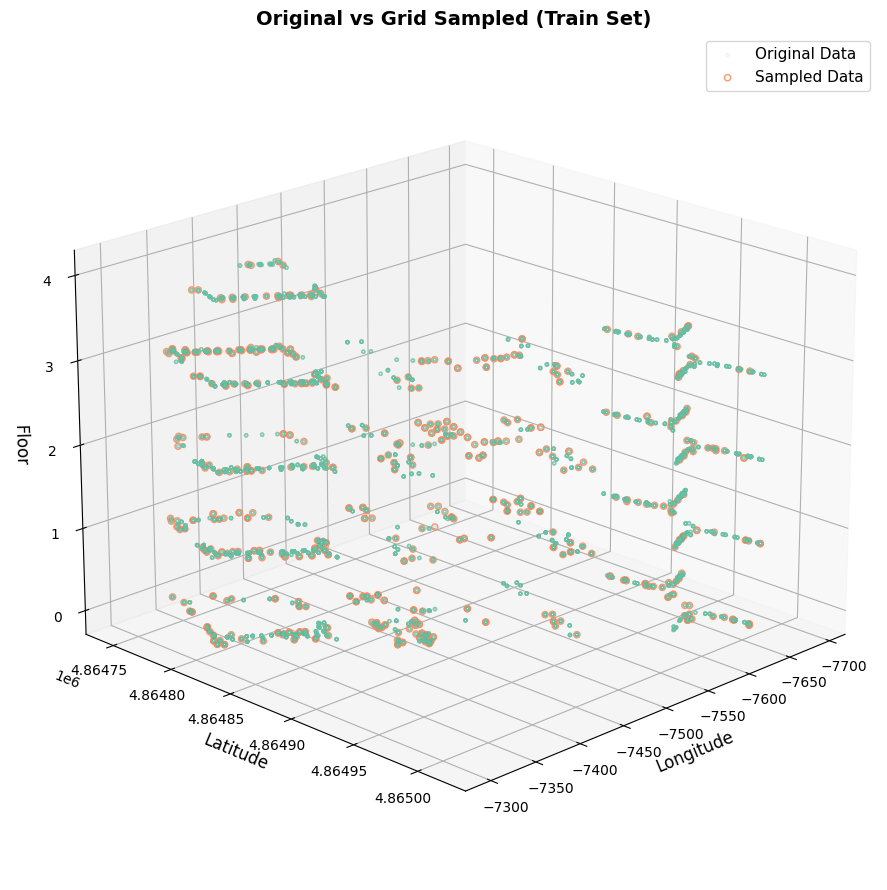

In [35]:
# 已完成 Uniform Grid Sampling 后的数据
sampled_data = uniform_grid_sampling(train_df, grid_size=5, samples_per_cell=2)

# 可视化对比
visualize_sampling_3d(train_df, sampled_data, title='Original vs Grid Sampled (Train Set)')


In [7]:
print(sampled_data.head(5))

   WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  \
0     100     100     100     100     100     100     100     100     100   
1     100     100     100     100     100     100     100     100     100   
2     100     100     100     100     100     100     100     100     100   
3     100     100     100     100     100     100     100     100     100   
4     100     100     100     100     100     100     100     100     100   

   WAP010  ...    LONGITUDE      LATITUDE  FLOOR  BUILDINGID  SPACEID  \
0     100  ... -7303.674135  4.864812e+06      0           2      121   
1     100  ... -7303.674135  4.864812e+06      0           2      121   
2     100  ... -7300.818990  4.864818e+06      0           2      122   
3     100  ... -7300.818990  4.864818e+06      0           2      122   
4     100  ... -7304.483600  4.864821e+06      0           2      122   

   RELATIVEPOSITION  USERID  PHONEID   TIMESTAMP       grid_id  
0                 1      10      

In [8]:
import numpy as np

def compute_global_variance(sampled_df, rssi_cols, lon_col='LONGITUDE', lat_col='LATITUDE', floor_col='FLOOR', tau=5.0, std_threshold=10.0):
    """
    基于空间邻域估计每个 MAC 的全局方差，并排除局部异常波动（如 std > 10 dBm）

    Parameters:
        sampled_df: DataFrame，包含RSSI和位置
        rssi_cols: RSSI列名列表或切片，如 sampled_df.columns[:520]
        lon_col, lat_col, floor_col: 表示位置的列名
        tau: 邻域半径（米）
        std_threshold: 单个MAC在局部区域内的最大标准差，超过将视为异常（默认10dBm）

    Returns:
        V_g: shape = (1, m) 的 numpy 数组，表示每列（MAC）的全局方差
    """
    rssi_data = sampled_df[rssi_cols].values  # N × m
    positions = sampled_df[[lon_col, lat_col, floor_col]].values  # N × 3

    N, m = rssi_data.shape
    local_variances = []

    for i in range(N):
        xi, yi, fi = positions[i]

        # 寻找邻域：同楼层 & 欧式距离 < tau
        distances = np.sqrt((positions[:, 0] - xi)**2 + (positions[:, 1] - yi)**2)
        same_floor = positions[:, 2] == fi
        neighbors_idx = np.where((distances < tau) & same_floor)[0]

        neighborhood_rssi = rssi_data[neighbors_idx]

        # 局部方差
        var_li = np.var(neighborhood_rssi, axis=0, ddof=0)
        std_li = np.sqrt(var_li)

        # 如果标准差 > 阈值，就将该维度设为 NaN（排除异常方差）
        var_li[std_li > std_threshold] = np.nan

        local_variances.append(var_li)

    # 局部方差矩阵 (N, m)
    V_l = np.vstack(local_variances)

    # 使用 nanmean 忽略异常值
    V_g = np.nanmean(V_l, axis=0, keepdims=True)  # shape: (1, m)

    return V_g


In [9]:
# 假设 sampled_data 已准备好
rssi_cols = sampled_data.columns[:520]  # RSSI列
V_g = compute_global_variance(sampled_data, rssi_cols, tau=5.0)

print("每个MAC的全局方差 shape:", V_g.shape)  # 应该是 (1, 520)
print(V_g)

每个MAC的全局方差 shape: (1, 520)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.76166678e-01 7.04225352e-03 3.89273356e-02
  0.00000000e+00 8.65051903e-04 6.85171095e-01 3.49919305e-01
  8.42251309e-01 1.15553603e-01 1.80679785e-01 1.73524150e-01
  0.00000000e+00 0.00000000e+00 1.05034722e-01 7.05574913e-02
  3.46620451e-03 0.00000000e+00 5.98591549e-02 3.16901408e-02
  9.07504363e-02 1.73611111e-01 5.69395018e-02 4.35168739e-02
  4.66549296e-02 6.00706714e-02 2.21238938e-02 3.53982301e-02
  6.12169196e-01 3.86350322e-01 3.05344365e-01 4.64678697e-01
  4.21037296e-01 2.86513545e-01 1.42172203e-01 1.33919156e-01
  4.54545455e-02 2.96684119e-02 7.46924429e-03 2.22993827e-01
  1.13240418e-02 1.92307692e-02 2.50000000e-02 2.86956522e-02
  3.11418685e-02 0.00000000e+00 1.22760172e+00 8.28390451e-01
  6.80056228e-01 7.42365451e-01 0.00000000e+00 0.00000000e+00
  3.19715808e-02 2.21238938e-02 2.76266417e-01 4.01869159e-01
  1.89483375e+00 1.26255598e+00 1.09567107e

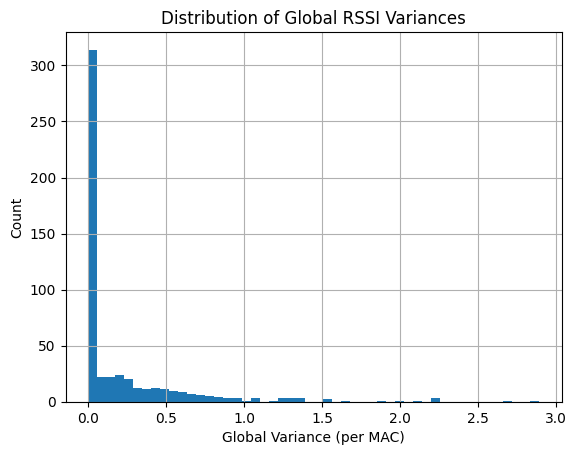

In [10]:
# 方差分布图
import matplotlib.pyplot as plt

plt.hist(V_g.flatten(), bins=50)
plt.xlabel("Global Variance (per MAC)")
plt.ylabel("Count")
plt.title("Distribution of Global RSSI Variances")
plt.grid(True)
plt.show()


In [11]:
def add_gaussian_noise_by_variance_masked(X, V_g, factor=1.0, missing_value=100):
    """
    添加高斯噪声（考虑每列方差），跳过缺失项（RSSI=-110）
    """
    std_g = np.sqrt(V_g)  # shape: (1, m)
    noise = factor * std_g * np.random.randn(*X.shape)  # shape: N × m

    X_aug = X.astype(float).copy()  # 转为float以支持加噪声
    mask = X_aug != missing_value   # 只对有效RSSI加噪声
    X_aug[mask] += noise[mask]
    return X_aug


In [12]:
X_rssi = train_df[rssi_cols].values
X_aug = add_gaussian_noise_by_variance_masked(X_rssi, V_g, factor=1.0)

# 构造带噪DataFrame
train_df_noisy = train_df.copy()
train_df_noisy[rssi_cols] = X_aug

# # 拼接原始与带噪数据：Φ = concat(Φ_a, Φ)
# data_augmented = pd.concat([sampled_data, sampled_data_noisy], axis=0).reset_index(drop=True)


In [13]:
# 保存样本集和噪声集合

# 自动创建目录
os.makedirs('../data', exist_ok=True)

# sampled_data.to_csv('../data/sampled_data.csv', index=False)
# sampled_data_noisy.to_csv('../data/sampled_data_noisy.csv', index=False)
train_df_noisy.to_csv('../data/train_noisy2.csv', index=False)
# print(sampled_data.head(5))
# print(sampled_data_noisy.head(5))

In [14]:
from sklearn.decomposition import PCA

def plot_pca_scatter(X_orig, X_noisy, title='PCA Projection: Original vs Noisy RSSI'):
    pca = PCA(n_components=2)
    X_combined = np.vstack([X_orig, X_noisy])
    X_proj = pca.fit_transform(X_combined)

    n = len(X_orig)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_proj[:n, 0], X_proj[:n, 1], s=8, alpha=0.4, label='Original', color='blue')
    plt.scatter(X_proj[n:, 0], X_proj[n:, 1], s=8, alpha=0.5, label='Noisy', color='orange')
    plt.xlabel('PCA-1')
    plt.ylabel('PCA-2')
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [15]:
plot_pca_scatter(sampled_data, sampled_data_noisy)


NameError: name 'sampled_data_noisy' is not defined